In [962]:
import os
import numpy as np
import tifffile
from tqdm import tqdm


def read_sequence(folder_path):
    """
    Read a sequence of TIFF files in a folder as a 3D volume.

    Args:
    folder_path (str): Path to the folder containing TIFF files.

    Returns:
    numpy.ndarray: A 3D array where each slice corresponds to a TIFF file.
    """

    # List and sort the TIFF files
    tiff_files = sorted(
        [
            os.path.join(folder_path, f)
            for f in os.listdir(folder_path)
            if (f.endswith(".tiff") or f.endswith(".tif"))
        ]
    )

    tiff_sequence = tifffile.TiffSequence(tiff_files)

    # Get the total number of TIFF files
    total_files = len(tiff_files)

    # Read each TIFF file and update progress
    volume = []
    with tqdm(total=total_files, desc="Progress") as pbar:
        for i, file_path in enumerate(tiff_files):
            slice_data = tifffile.imread(file_path)
            volume.append(slice_data)

            # Update progress
            pbar.update(1)

    return np.array(volume)

In [963]:
def write_sequence(folder_path, name, volume):
    """
    Save a 3D volume as a sequence of TIFF files in a folder.

    Args:
    folder_path (str): Path to the folder where TIFF files will be saved.
    name (str): Name of the TIFF files.
    volume (numpy.ndarray): A 3D array where each slice corresponds to an image.
    """

    folder_path = folder_path / name

    # Create the folder if it doesn't exist
    Path(folder_path).mkdir(parents=True, exist_ok=True)

    # Save each slice as a TIFF file with progress bar
    with tqdm(total=volume.shape[0], desc="Saving") as pbar:
        for i in range(volume.shape[0]):
            tifffile.imwrite(f"{folder_path}/{name}_{i:04d}.tif", volume[i])
            pbar.update(1)

    print("Saving complete.")

In [964]:
from pathlib import Path

folder1 = Path(
    "C:/Users/alberto.vicente/Documents/temporal/volumenes/2/bot_eq_reg_aligned_centered"
)
folder2 = Path(
    "C:/Users/alberto.vicente/Documents/temporal/volumenes/2/top_eq_reg_aligned_centered"
)

bot = read_sequence(folder1)
top = read_sequence(folder2)

# flip slices order in top volume
top = top[::-1]

Progress:   2%|▏         | 93/4425 [00:00<00:09, 458.75it/s]

Progress: 100%|██████████| 4455/4455 [00:08<00:00, 539.25it/s]


In [965]:
from skimage.filters import threshold_otsu


def autothreshold_slice(slice_data, top_threshold=0):
    """
    Autothreshold a 2D slice using Otsu's method.

    Args:
    slice_data (numpy.ndarray): 2D array representing the slice data.

    Returns:
    numpy.ndarray: Binary thresholded slice.
    """
    if top_threshold > 0:
        slice_data[slice_data >= top_threshold] = 0
    threshold_value = threshold_otsu(slice_data)
    thresholded_slice = slice_data > threshold_value
    return thresholded_slice

In [966]:
def autothreshold_volume(volume, top_threshold=0):
    """
    Apply autothreshold_slice to each slice in a volume with a progress bar.

    Args:
    volume (numpy.ndarray): A 3D array where each slice corresponds to an image.

    Returns:
    numpy.ndarray: A 3D array where each slice is thresholded.
    """
    thresholded_volume = []

    with tqdm(total=volume.shape[0], desc="Thresholding") as pbar:
        for i in range(volume.shape[0]):
            thresholded_slice = autothreshold_slice(volume[i], top_threshold)
            thresholded_volume.append(thresholded_slice)
            pbar.update(1)

    return np.array(thresholded_volume)

In [967]:
from concurrent.futures import ThreadPoolExecutor
from skimage.measure import label
from skimage.measure import regionprops


def autothreshold_slice_2(args):
    """
    Autothreshold a 2D slice using Otsu's method.

    Args:
    slice_data (numpy.ndarray): 2D array representing the slice data.

    Returns:
    numpy.ndarray: Binary thresholded slice.
    """

    slice_data, top_threshold = args

    if top_threshold > 0:
        slice_data[slice_data >= top_threshold] = 0
    threshold_value = threshold_otsu(slice_data)
    thresholded_slice = slice_data > threshold_value

    # Label the objects in the thresholded slice
    labeled_slice = label(thresholded_slice)

    # Get the properties of each labeled region
    regions = regionprops(labeled_slice)

    # Find the largest connected component
    largest_component = max(regions, key=lambda region: region.area)

    # Create a mask to keep only the largest component
    mask = np.zeros_like(labeled_slice)
    mask[labeled_slice == largest_component.label] = 1

    # Apply the mask to the thresholded slice
    thresholded_slice = thresholded_slice * mask

    return thresholded_slice


def autothreshold_volume_concurrent(volume, top_threshold=0):
    """
    Apply autothreshold_slice to each slice in a volume concurrently with a progress bar.

    Args:
    volume (numpy.ndarray): A 3D array where each slice corresponds to an image.

    Returns:
    numpy.ndarray: A 3D array where each slice is thresholded.
    """
    thresholded_volume = np.zeros_like(volume)

    with ThreadPoolExecutor() as executor:
        args = [(volume[i], top_threshold) for i in range(volume.shape[0])]
        for i, result in enumerate(
            tqdm(
                executor.map(autothreshold_slice_2, args),
                total=volume.shape[0],
                desc="Thresholding",
            )
        ):
            thresholded_volume[i] = result

    return np.array(thresholded_volume) * 255

In [968]:
def compare_images(args):
    """
    Compare two images using the chi-square metric.

    Args:
    image1 (numpy.ndarray): First image.
    image2 (numpy.ndarray): Second image.

    Returns:
    float: Chi-square distance between the two images.
    """
    image1, image2, i, j = args

    # Flatten the images
    image1_flat = image1.flatten()
    image2_flat = image2.flatten()

    # Calculate the histogram of each image
    hist1, _ = np.histogram(image1_flat, bins=256, range=(0, 256))
    hist2, _ = np.histogram(image2_flat, bins=256, range=(0, 256))

    # normalize histograms
    hist1 = hist1 / np.sum(hist1)
    hist2 = hist2 / np.sum(hist2)

    # Calculate the chi-square distance
    chi_square = np.sum((hist1 - hist2) ** 2 / (hist1 + hist2 + 1e-10))

    return i, j, chi_square

In [969]:
def compare_images_2(args):
    """
    Compare two images using the chi-square metric.

    Args:
    image1 (numpy.ndarray): First image.
    image2 (numpy.ndarray): Second image.

    Returns:
    float: Chi-square distance between the two images.
    """
    image1, image2, i, j = args

    # Pad the smaller image with zeros to match the size of the larger image
    if image1.shape != image2.shape:
        max_height = max(image1.shape[0], image2.shape[0])
        max_width = max(image1.shape[1], image2.shape[1])
        image1_padded = np.zeros((max_height, max_width))
        image2_padded = np.zeros((max_height, max_width))
        image1_padded[: image1.shape[0], : image1.shape[1]] = image1
        image2_padded[: image2.shape[0], : image2.shape[1]] = image2
        image1 = image1_padded
        image2 = image2_padded

    # Flatten the images
    image1_flat = image1.flatten()
    image2_flat = image2.flatten()

    # Calculate the cosine_similarity distance
    epsilon = 1e-7
    cosine_similarity = (
        np.dot(image1_flat, image2_flat)
        / (np.linalg.norm(image1_flat) + epsilon)
        * (np.linalg.norm(image2_flat) + epsilon)
    )
    return i, j, -cosine_similarity

In [970]:
from skimage.metrics import structural_similarity as ssim


def compare_images_3(args):
    """
    Compare two images using the chi-square metric.

    Args:
    image1 (numpy.ndarray): First image.
    image2 (numpy.ndarray): Second image.

    Returns:
    float: Chi-square distance between the two images.
    """
    image1, image2, i, j = args

    # Pad the smaller image with zeros to match the size of the larger image
    if image1.shape != image2.shape:
        max_height = max(image1.shape[0], image2.shape[0])
        max_width = max(image1.shape[1], image2.shape[1])
        image1_padded = np.zeros((max_height, max_width))
        image2_padded = np.zeros((max_height, max_width))
        image1_padded[: image1.shape[0], : image1.shape[1]] = image1
        image2_padded[: image2.shape[0], : image2.shape[1]] = image2
        image1 = image1_padded
        image2 = image2_padded
    image1 = image1
    image2 = image2
    similarity = ssim(image1, image2, multichannel=False)

    return i, j, -similarity

In [971]:
import cv2


def compare_images_4(args):
    """
    Compare two images using the chi-square metric.

    Args:
    image1 (numpy.ndarray): First image.
    image2 (numpy.ndarray): Second image.

    Returns:
    float: Chi-square distance between the two images.
    """
    image1, image2, i, j = args

    # Pad the smaller image with zeros to match the size of the larger image
    if image1.shape != image2.shape:
        max_height = max(image1.shape[0], image2.shape[0])
        max_width = max(image1.shape[1], image2.shape[1])
        image1_padded = np.zeros((max_height, max_width))
        image2_padded = np.zeros((max_height, max_width))
        image1_padded[: image1.shape[0], : image1.shape[1]] = image1
        image2_padded[: image2.shape[0], : image2.shape[1]] = image2
        image1 = image1_padded
        image2 = image2_padded

    # convert to 8bits both images
    image1 = np.uint8(image1)
    image2 = np.uint8(image2)

    image1 = image1
    image2 = image2

    # Initialize the ORB detector
    orb = cv2.ORB_create()

    # Find the keypoints and descriptors with ORB
    kp1, des1 = orb.detectAndCompute(image1, None)
    kp2, des2 = orb.detectAndCompute(image2, None)

    # Create a BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors
    matches = bf.match(des1, des2)

    # Sort them in the order of their distance
    matches = sorted(matches, key=lambda x: x.distance)

    # Define a threshold for a good match (this can be adjusted based on your needs)
    threshold = 30

    # Count the number of good matches
    good_matches = [i for i in matches if i.distance < threshold]

    # Calculate the similarity score as the ratio of good matches to total matches
    similarity_score = len(good_matches) / len(matches)

    return i, j, -similarity_score

In [972]:
import pystackreg


def compare_images_5(args, show=False):
    image1, image2, borderx, bordery, i, j = args

    # Pad the smaller image with zeros to match the size of the larger image
    if image1.shape != image2.shape:
        max_height = max(image1.shape[0], image2.shape[0])
        max_width = max(image1.shape[1], image2.shape[1])
        image1_padded = np.zeros((max_height, max_width))
        image2_padded = np.zeros((max_height, max_width))
        image1_padded[: image1.shape[0], : image1.shape[1]] = image1
        image2_padded[: image2.shape[0], : image2.shape[1]] = image2
        image1 = image1_padded
        image2 = image2_padded

    image1 = image1
    image2 = image2

    # convert to 8bits both images
    image1 = np.uint8(image1)
    image2 = np.uint8(image2)

    # apply canny edge detection in both images
    # image1 = cv2.Canny(image1,100,200) > 0
    # image2 = cv2.Canny(image2,100,200) > 0

    # iniziialize the stackreg object
    sr = pystackreg.StackReg(pystackreg.StackReg.BILINEAR)

    # calculate transformation matrix
    transform = sr.register(image1, image2)

    # sum all the absolute values of the transformation matrix
    similarity_score = np.sum(np.abs(transform))

    if show:
        print(transform)

        # show image1 and image2 using matplotlib in the same figure
        plt.subplot(121)
        plt.imshow(image1, cmap="gray")
        plt.title("image1")
        plt.subplot(122)
        plt.imshow(image2, cmap="gray")
        plt.title("image2")
        plt.show()

    return i, j, similarity_score

In [973]:
def compare_images_all(args, show=False):
    def compare_images(args):
        """
        Compare two images using the chi-square metric.

        Args:
        image1 (numpy.ndarray): First image.
        image2 (numpy.ndarray): Second image.

        Returns:
        float: Chi-square distance between the two images.
        """
        image1, image2, i, j = args

        # Flatten the images
        image1_flat = image1.flatten()
        image2_flat = image2.flatten()

        # Calculate the histogram of each image
        hist1, _ = np.histogram(image1_flat, bins=256, range=(0, 256))
        hist2, _ = np.histogram(image2_flat, bins=256, range=(0, 256))

        # normalize histograms
        hist1 = hist1 / np.sum(hist1)
        hist2 = hist2 / np.sum(hist2)

        # Calculate the chi-square distance
        chi_square = np.sum((hist1 - hist2) ** 2 / (hist1 + hist2 + 1e-10))

        return i, j, chi_square

    def compare_images_3(args):
        """
        Compare two images using the chi-square metric.

        Args:
        image1 (numpy.ndarray): First image.
        image2 (numpy.ndarray): Second image.

        Returns:
        float: Chi-square distance between the two images.
        """
        image1, image2, i, j = args

        # Pad the smaller image with zeros to match the size of the larger image
        if image1.shape != image2.shape:
            max_height = max(image1.shape[0], image2.shape[0])
            max_width = max(image1.shape[1], image2.shape[1])
            image1_padded = np.zeros((max_height, max_width))
            image2_padded = np.zeros((max_height, max_width))
            image1_padded[: image1.shape[0], : image1.shape[1]] = image1
            image2_padded[: image2.shape[0], : image2.shape[1]] = image2
            image1 = image1_padded
            image2 = image2_padded
        image1 = image1
        image2 = image2
        similarity = ssim(image1, image2, multichannel=False)

        return i, j, -similarity

    image1, image2, i, j, rois = args
    image1 = image1.copy()
    image2 = image2.copy()
    image1[image1 < 120] = 0
    image2[image2 < 120] = 0
    distance = 0
    for r in rois:
        x0, y0, x1, y1 = r
        args1 = [
            image1[min(x0, x1) : max(x0, x1), min(y0, y1) : max(y0, y1)],
            image2[min(x0, x1) : max(x0, x1), min(y0, y1) : max(y0, y1)],
            i,
            j,
        ]
        distance_a = np.array([compare_images(args1), compare_images_3(args1)])[
            :, -1
        ].sum()
        # show using pyplot the two images of args1
        if show:
            plt.subplot(121)
            plt.imshow(args1[0], cmap="gray")
            plt.title(str(distance_a))
            plt.subplot(122)
            plt.imshow(args1[1], cmap="gray")
            plt.title("image2")
            plt.show()
        distance += distance_a
    return i, j, distance

In [974]:
def compare_slices(volume1, volume2, borderx=400, bordery=100):
    """
    Compare every slice of two volumes and return a list of distances.

    Args:
    volume1 (numpy.ndarray): First volume.
    volume2 (numpy.ndarray): Second volume.

    Returns:
    list: List of distances between each pair of slices.
    """

    distances = []

    # List combination of indexes from each volume
    indexes = [(i, j) for i in range(volume1.shape[0]) for j in range(volume2.shape[0])]

    # Create a progress bar
    with tqdm(total=len(indexes), desc="Comparing slices") as pbar:
        # Compare each pair of slices
        for i, j in indexes:
            # Crop the slices

            # Compare the slices
            distance = compare_images_2(
                [volume1[i], volume2[j], borderx, bordery, i, j]
            )
            distances.append(distance)

            # Update the progress bar
            pbar.update(1)

    return np.array(distances)

In [975]:
def compare_slices_concurrent(
    volume1, volume2, borderx=400, bordery=100, start=0, end=-1, n_chunks=100
):
    """
    Compare every slice of two volumes concurrently and return a list of distances.

    Args:
    volume1 (numpy.ndarray): First volume.
    volume2 (numpy.ndarray): Second volume.

    Returns:
    list: List of distances between each pair of slices.
    """
    distances = []

    # List combination of indexes from each volume
    indexes = [
        (i + start, j)
        for i in range(volume1[start:].shape[0])
        for j in range(volume2[:end].shape[0])
        if i < j
    ]

    # divide the indexes in chunks
    chunks = np.array_split(indexes, n_chunks)

    for indexes in chunks:
        distances_aux = []

        # Create a thread pool executor
        with ThreadPoolExecutor() as executor:
            # Create a list of arguments for each pair of slices with a progress bar
            args = [
                (volume1[i], volume2[j], borderx, bordery, i, j)
                for i, j in tqdm(indexes, total=len(indexes), desc="Creating arguments")
            ]
            # Compare each pair of slices concurrently
            for distance in tqdm(
                executor.map(compare_images, args),
                total=len(indexes),
                desc="Comparing Slices",
            ):
                distances_aux.append(np.array(distance))

        # get the minimum distance of distances_aux
        distances_aux = np.array(distances_aux)
        min_distance = np.argmin(distances_aux[:, 2])
        distances.append(distances_aux[min_distance])

    return np.array(distances)

In [976]:
def compare_slices_concurrent_2(
    volume1,
    volume2,
    length,
    resolution,
    rois,
    start=0,
    end=-1,
    n_chunks=100,
    range_slices=200,
):
    """
    Compare every slice of two volumes concurrently and return a list of distances.

    Args:
    volume1 (numpy.ndarray): First volume.
    volume2 (numpy.ndarray): Second volume.

    Returns:
    list: List of distances between each pair of slices.
    """
    distances = []

    # List indexes of volume 1 only
    indexes = [(i + start) for i in range(volume1[start:end].shape[0])]

    # print(indexes)

    # find candidates

    indexes = find_candidates_volume(
        volume1, volume2, length, resolution, indexes, range=range_slices
    )

    # divide the indexes in chunks
    chunks = np.array_split(indexes, n_chunks)

    for indexes in chunks:
        distances_aux = []

        # Create a thread pool executor
        with ThreadPoolExecutor() as executor:
            # Create a list of arguments for each pair of slices with a progress bar
            args = [
                (volume1[i], volume2[j], i, j, rois)
                for i, j in tqdm(indexes, total=len(indexes), desc="Creating arguments")
            ]
            # Compare each pair of slices concurrently
            for distance in tqdm(
                executor.map(compare_images_all, args),
                total=len(indexes),
                desc="Comparing Slices",
            ):
                distances_aux.append(np.array(distance))

        # get the 10 minimum distances of distances_aux
        distances_aux = np.array(distances_aux)
        min_distances = np.argsort(distances_aux[:, 2])[:10]
        distances.append(distances_aux[min_distances])

    return np.array(distances)

In [977]:
from skimage.transform import resize
from tensorflow.keras.applications.mobilenet import preprocess_input


def prepare_images_for_model(img1):
    img1 = img1
    img1 = img1.astype(np.float32)

    # resize images to 224x224
    img1 = resize(img1, (224, 224))

    # prepare the images for the model, they are greyscale so we add a channel dimension

    img1 = np.expand_dims(img1, axis=-1)

    img1 = np.repeat(img1, 3, axis=-1)

    # prepare them for the model

    img1 = preprocess_input(img1)

    img1 = img1.reshape((1, 224, 224, 3))

    return img1

In [978]:
from scipy.spatial import distance as dist


def compare_features(args):
    features1, features2, i, j = args

    d1 = dist.euclidean(features1.flatten(), features2.flatten())

    return i, j, d1

In [979]:
# load vgg16 model and remove classification layers
from tensorflow.keras.applications.mobilenet import MobileNet


def compare_slices_concurrent_ai(
    volume1,
    volume2,
    length,
    resolution,
    rois,
    start=0,
    end=-1,
    n_chunks=100,
    range_slices=200,
):
    """
    Compare every slice of two volumes concurrently and return a list of distances.

    Args:
    volume1 (numpy.ndarray): First volume.
    volume2 (numpy.ndarray): Second volume.

    Returns:
    list: List of distances between each pair of slices.
    """
    # initialize model

    # load model without classifier layers for greyscale images
    model = MobileNet(include_top=False, input_shape=(224, 224, 3))

    distances = []

    # List indexes of volume 1 only
    indexes = [(i + start) for i in range(volume1[start:end].shape[0])]

    # print(indexes)

    # find candidates

    indexes = find_candidates_volume(
        volume1, volume2, length, resolution, indexes, range=range_slices
    )

    # get the first and last candidate
    first = indexes[0][1]
    last = indexes[-1][1]

    x0, y0, x1, y1 = rois[0]

    images1 = [
        volume1[i, min(x0, x1) : max(x0, x1), min(y0, y1) : max(y0, y1)]
        for i in tqdm(range(start, end), desc="Getting images from volume 1")
    ]
    images2 = [
        volume2[i, min(x0, x1) : max(x0, x1), min(y0, y1) : max(y0, y1)]
        for i in tqdm(range(first, last + 1), desc="Getting images from volume 2")
    ]

    # prepare images for model concurrently
    with ThreadPoolExecutor() as executor:
        images1_prepared = list(
            tqdm(
                executor.map(prepare_images_for_model, images1),
                total=len(images1),
                desc="Preparing images for model",
            )
        )
        images2_prepared = list(
            tqdm(
                executor.map(prepare_images_for_model, images2),
                total=len(images2),
                desc="Preparing images for model",
            )
        )

    images1_prepared = np.array(images1_prepared).reshape((-1, 224, 224, 3))
    images2_prepared = np.array(images2_prepared).reshape((-1, 224, 224, 3))

    # get features from images
    features1 = model.predict(np.array(images1_prepared).reshape((-1, 224, 224, 3)))
    features2 = model.predict(np.array(images2_prepared).reshape((-1, 224, 224, 3)))

    # prepare args for compare_features
    args = [(features1[i - start], features2[j - first], i, j) for i, j in indexes]

    # Create a thread pool executor
    with ThreadPoolExecutor() as executor:
        # Create a list of arguments for each pair of slices with a progress bar
        for distance in tqdm(
            executor.map(compare_features, args),
            total=len(indexes),
            desc="Comparing Slices",
        ):
            distances.append(np.array(distance))

    return np.array(distances)

In [980]:
def find_candidates_slice(
    frameid, length, resolution, vol1shape, vol2shape, range_slices=200, show=False
):
    """
    Find the candidates for a given frameid, length and resolution.

    Args:
    frameid (int): Frame id of the first volume.
    length (int): Length of the sample scanned in two volumes in millimeters.
    resolution (int): Resolution of the scan.
    vol1shape (int): Number of slices in the first volume.
    vol2shape (int): Number of slices in the second volume.

    Returns:
    list: List of candidates to be the same slice in the second volume as frameid in the first.
    """

    # Calculate the number of slices needed to cover the length of the sample
    n_slices = int(length / resolution)

    # Calulate the remaining slices needed to cover the length of the sample
    remaining = n_slices - frameid

    # Calculate where should the first slice of he second volume be to fit the length of the sample
    start_vol2 = vol2shape - remaining

    # print all
    if show:
        print(
            f"frameid: {frameid}, n_slices: {n_slices}, remaining: {remaining}, start_vol2: {start_vol2}"
        )

    # define range
    start = np.clip(start_vol2 - range_slices // 2, a_min=0, a_max=None)
    end = np.clip(start_vol2 + range_slices // 2, a_min=None, a_max=vol2shape)

    # Create a list of candidates, all numbers in a range of 200 being start_vol2 the center
    candidates = [i for i in range(start, end)]

    # Create tuples of one candidate and the frameid
    return np.array([(frameid, candidate) for candidate in candidates])


def find_candidates_volume(vol1, vol2, length, resolution, indexes, range=200):
    candidates = []

    for i in indexes:
        candidates.append(
            find_candidates_slice(
                i, length, resolution, vol1.shape[0], vol2.shape[0], range_slices=range
            )
        )

    # concatenate all candidates
    candidates = np.concatenate(candidates)

    return candidates

In [981]:
import matplotlib.pyplot as plt
from skimage import measure


# create a function that return the x and y spatial shift between two slices
def find_shift(s1, s2, show=False, top_threshold=255):
    """
    Find the x and y spatial shift between two slices.

    Args:
    slice1 (numpy.ndarray): First slice.
    slice2 (numpy.ndarray): Second slice.

    Returns:
    tuple: Tuple with the x and y shift.
    """
    # check if the slice is 8bit
    if s1.dtype != np.uint8:
        top_threshold = 65535

    # copy slices
    slice1 = s1.copy()
    slice2 = s2.copy()

    # make 0 every pixel above the threshold in each slice
    slice1[slice1 > top_threshold] = 0
    slice2[slice2 > top_threshold] = 0

    # autothreshold the slices using otsu
    thresh1 = threshold_otsu(slice1)
    thresh2 = threshold_otsu(slice2)

    # apply threshold to the slices
    slice1 = slice1 > thresh1
    slice2 = slice2 > thresh2

    # label the slices
    slice1 = measure.label(slice1)
    slice2 = measure.label(slice2)

    # get the largest component of each slice
    regprops1 = measure.regionprops(slice1)
    regprops2 = measure.regionprops(slice2)
    largest1 = regprops1[np.argmax([regprop.area for regprop in regprops1])].label
    largest2 = regprops2[np.argmax([regprop.area for regprop in regprops2])].label
    slice1[slice1 != largest1] = 0
    slice2[slice2 != largest2] = 0

    # calculate the cross correlation between the two slices
    corr = np.fft.fftshift(np.fft.fft2(slice1)) * np.fft.fftshift(
        np.fft.fft2(slice2).conj()
    )

    # calculate the inverse fourier transform of the cross correlation
    corr = np.fft.ifft2(corr)

    # calculate the shift in x and y
    shift = np.unravel_index(np.argmax(corr), corr.shape)

    # print all
    if show:
        print(f"shift: {shift}, corr.shape: {corr.shape}")

        # shift the second slice so it matches the first
        shifted = np.roll(slice2, shift[0], axis=0)
        shifted = np.roll(shifted, shift[1], axis=1)

        # plot the two slices using matplotlib
        fig, ax = plt.subplots(1, 2, figsize=(10, 10))
        ax[0].imshow(slice1, cmap="gray")
        ax[1].imshow(shifted, cmap="gray")
        plt.show()

    # return the shift in x and y
    return shift


def shift_slice(args):
    """
    Shift a slice.

    Args:
    slice (numpy.ndarray): Slice to be shifted.
    shift (tuple): Tuple with the x and y shift.

    Returns:
    numpy.ndarray: Shifted slice.
    """
    # unpack args
    slice, shift = args
    # shift the slice
    shifted = np.roll(slice, shift[0], axis=0)
    shifted = np.roll(shifted, shift[1], axis=1)

    # return the shifted slice
    return shifted


def shift_volume_concurrent(volume, shift):
    """
    Apply autothreshold_slice to each slice in a volume concurrently with a progress bar.

    Args:
    volume (numpy.ndarray): A 3D array where each slice corresponds to an image.

    Returns:
    numpy.ndarray: A 3D array where each slice is thresholded.
    """
    thresholded_volume = np.zeros_like(volume)

    with ThreadPoolExecutor() as executor:
        args = [(volume[i], shift) for i in range(volume.shape[0])]
        for i, result in enumerate(
            tqdm(
                executor.map(shift_slice, args),
                total=volume.shape[0],
                desc="Thresholding",
            )
        ):
            thresholded_volume[i] = result

    return np.array(thresholded_volume)

In [982]:
# create a function that given two volumes, i and j as coincident slices, return a concatenated volume
def concatenate_volumes(vol1, vol2, i, j):
    """
    Concatenate two volumes.

    Args:
    vol1 (numpy.ndarray): First volume.
    vol2 (numpy.ndarray): Second volume.
    i (int): Slice id of the first volume.
    j (int): Slice id of the second volume.

    Returns:
    numpy.ndarray: Concatenated volume.
    """
    # concatenate the two volumes
    concatenated = np.concatenate((vol1[:i], vol2[j:]), axis=0)

    # return the concatenated volume
    return concatenated

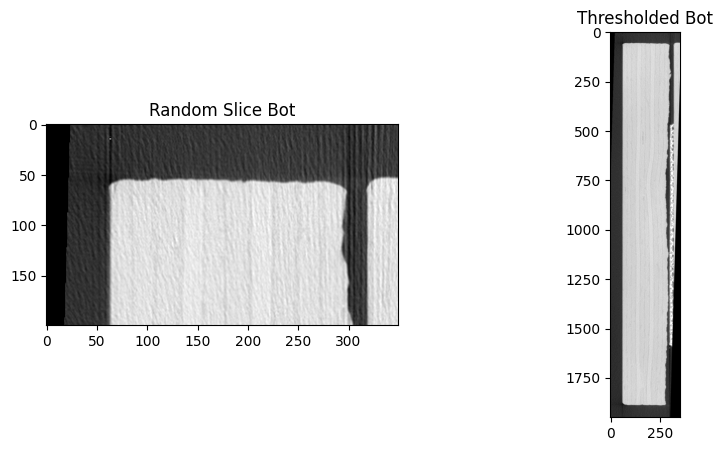

In [983]:
import random

random_slice_bot = random.choice(bot)
random_slice_bot = bot[3339]
x = 600
y = 1
random_slice_bot_cropped = random_slice_bot[0:200, :]

# Create a figure and axes
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot the random_slice_bot
ax[0].imshow(random_slice_bot_cropped, cmap="gray")
ax[0].set_title("Random Slice Bot")

# Plot the slice_bot
ax[1].imshow(random_slice_bot, cmap="gray")
ax[1].set_title("Thresholded Bot")

# Display the figure
plt.show()

In [984]:
resolution = 21.8 / 1000

slicesa = len(bot)

slicesb = len(top)

length = 166

slices_to_analyze = 10

lengtha = resolution * slicesa

lengthb = resolution * slicesb

end_top = length - lengtha

print("overlapping region is: ", end_top, "-", lengtha)

slice1 = int(end_top / resolution)

slice2 = int((lengtha - end_top) / resolution)

print("overlapping slice volume1 from:", slice1, "to", slicesa)
print("overlapping slice volume2 from:", 0, "-", slice2)

b = bot[slice1 : slice1 + slices_to_analyze]
t = top[0:slices_to_analyze]

# print slices range to be analyzed in each volume
print("bot slices from:", slice1, "to", slice1 + slices_to_analyze)
print("top slices from:", 0, "to", slices_to_analyze)

a = find_candidates_slice(
    3691, length, resolution, bot.shape[0], top.shape[0], range_slices=50, show=True
)

# print first and last candidate
print(a[0], a[-1])

overlapping region is:  69.535 - 96.465
overlapping slice volume1 from: 3189 to 4425
overlapping slice volume2 from: 0 - 1235
bot slices from: 3189 to 3199
top slices from: 0 to 10
frameid: 3691, n_slices: 7614, remaining: 3923, start_vol2: 532
[3691  507] [3691  556]


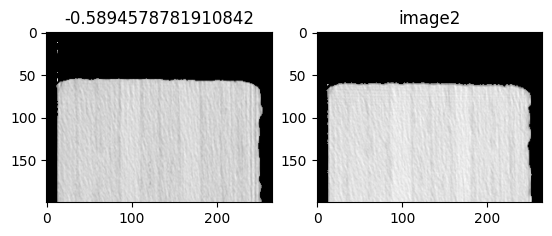

(3350, 0, -0.5894578781910842)


In [985]:
# try compare images 5
rois = [[0, 50, 200, 315]]
distance = compare_images_all([bot[3691], top[546], 3350, 0, rois], True)
print(distance)

In [986]:
start = slice1
end = slicesa
distancias_concurrente = compare_slices_concurrent_ai(
    bot,
    top,
    length,
    resolution,
    start=start,
    end=end,
    rois=rois,
    n_chunks=1,
    range_slices=50,
)

Preparing images for model: 100%|██████████| 1285/1285 [00:04<00:00, 288.47it/s]


41/41 [==============================] - 1s 31ms/step


Comparing Slices: 100%|██████████| 61800/61800 [00:03<00:00, 20464.67it/s] 


In [987]:
# i = 4254
# j = 1108

0.8592174 -1.0
1/1 [==============================] - 0s 38ms/step
(1, 7, 7, 1024) (1, 7, 7, 1024)
3153
173.35284423828125


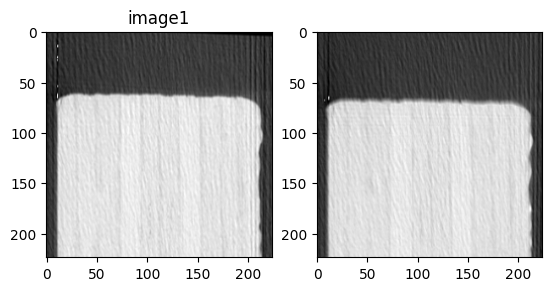

In [988]:
x0, y0, x1, y1 = rois[0]

img1 = bot[3691, min(x0, x1) : max(x0, x1), min(y0, y1) : max(y0, y1)]
img2 = top[538, min(x0, x1) : max(x0, x1), min(y0, y1) : max(y0, y1)]

# prepare them
img1 = prepare_images_for_model(img1)
img2 = prepare_images_for_model(img2)

print(img1.max(), img1.min())

# load vgg16 model and remove classification layers
model = MobileNet(include_top=False, input_shape=(224, 224, 3))

# plot first channel of each image
plt.subplot(121)
plt.imshow(img1[0, :, :, 0], cmap="gray")
plt.title("image1")
plt.subplot(122)
plt.imshow(img2[0, :, :, 0], cmap="gray")

# predict features
features1 = model.predict(img1)
features2 = model.predict(img2)

print(features1.shape, features2.shape)

# calculate distance
d1 = dist.euclidean(features1.flatten(), features2.flatten())

print(3691 - 538)
print(d1)

In [989]:
# get the minimum distance of distancias_concurrente
min_distance = np.argmin(distancias_concurrente[:, 2])
i = int(distancias_concurrente[min_distance][0])
j = int(distancias_concurrente[min_distance][1])
distance = distancias_concurrente[min_distance][2]
# print all
print(f"i: {i}, j: {j}, distance: {distance}")
print(i - j)
# 3159

i: 3374, j: 222, distance: 149.35572814941406
3152


In [990]:
# print the distances near the one from i j
for i in range(10):
    print(distancias_concurrente[min_distance - i])

[3374.          222.          149.35572815]
[3374.          221.          154.27088928]
[3374.          220.          165.52676392]
[3374.          219.          154.37322998]
[3374.          218.          149.96965027]
[3374.          217.          157.39372253]
[3374.          216.          162.87571716]
[3374.         215.         163.1791687]
[3374.          214.          162.21253967]
[3374.          213.          158.85678101]


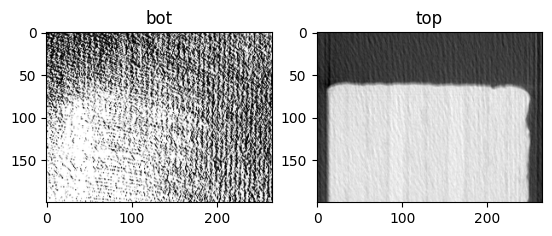

In [991]:
import matplotlib.pyplot as plt

# plot the slices applying the rois to them
# rois = [[0,50,200,315]]
x0, y0, x1, y1 = rois[0]
plt.subplot(121)
plt.imshow(bot[i, min(x0, x1) : max(x0, x1), min(y0, y1) : max(y0, y1)], cmap="gray")
plt.title("bot")
plt.subplot(122)
plt.imshow(top[j, min(x0, x1) : max(x0, x1), min(y0, y1) : max(y0, y1)], cmap="gray")
plt.title("top")
plt.show()